<a href="https://colab.research.google.com/github/singhamritanshu/EVA4S7/blob/master/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


plane plane truck  ship


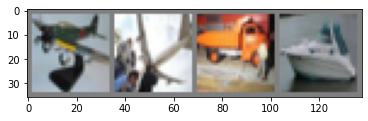

In [4]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.10),
            )#output size = 32, RF = 5

        self.pool1= nn.MaxPool2d(2,2) # output size = 16, RF = 10

        self.block2 = nn.Sequential( 
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.10),
        )# output size = 16, RF = 16

        self.pool2 = nn.MaxPool2d(2,2) # output size = 8, RF = 32

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding = 1, bias = False, groups=64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.10),
        ) # output size 8, RF = 36

        self.pool3= nn.MaxPool2d(2,2) # output size = 4, RF = 72

        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding =1, dilation = 2, bias =False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )#output = 4, RF = 74

        self.avg = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc= nn.Linear(in_features =128,  out_features = 10)

    def forward(self,x):
        #x = x.view(x.size(0), -1)
        x=self.block1(x)
        x=self.pool1(x)
        x=self.block2(x)
        x=self.pool2(x)
        x=self.block3(x)
        x=self.pool3(x)
        x=self.block4(x)
        x=self.avg(x)
        x = x.view(-1, 128)
        x=self.fc(x)
        return x
net = Net()

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,216
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
           Dropout-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,432
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,864
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
  )
  (pool2

In [33]:
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
       # inputs, labels = data[0].to(device), data[1].to(device)
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)
        #data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 1.828
[1,  4000] loss: 1.582
[1,  6000] loss: 1.397
[1,  8000] loss: 1.303
[1, 10000] loss: 1.239
[1, 12000] loss: 1.170
[2,  2000] loss: 1.119
[2,  4000] loss: 1.068
[2,  6000] loss: 1.016
[2,  8000] loss: 1.039
[2, 10000] loss: 0.995
[2, 12000] loss: 0.965
[3,  2000] loss: 0.908
[3,  4000] loss: 0.885
[3,  6000] loss: 0.888
[3,  8000] loss: 0.873
[3, 10000] loss: 0.859
[3, 12000] loss: 0.876
[4,  2000] loss: 0.805
[4,  4000] loss: 0.802
[4,  6000] loss: 0.828
[4,  8000] loss: 0.799
[4, 10000] loss: 0.805
[4, 12000] loss: 0.778
[5,  2000] loss: 0.728
[5,  4000] loss: 0.734
[5,  6000] loss: 0.714
[5,  8000] loss: 0.728
[5, 10000] loss: 0.711
[5, 12000] loss: 0.718
[6,  2000] loss: 0.682
[6,  4000] loss: 0.704
[6,  6000] loss: 0.699
[6,  8000] loss: 0.700
[6, 10000] loss: 0.665
[6, 12000] loss: 0.679
[7,  2000] loss: 0.621
[7,  4000] loss: 0.640
[7,  6000] loss: 0.634
[7,  8000] loss: 0.633
[7, 10000] loss: 0.644
[7, 12000] loss: 0.621
[8,  2000] loss: 0.578
[8,  4000] 

GroundTruth:    cat  ship  ship plane


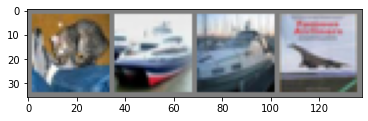

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
#outputs = outputs.cuda()
images = images.cuda()
outputs = net(images)


In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car plane


In [37]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device),labels.to(device)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


In [38]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 90 %
Accuracy of  bird : 72 %
Accuracy of   cat : 65 %
Accuracy of  deer : 79 %
Accuracy of   dog : 71 %
Accuracy of  frog : 82 %
Accuracy of horse : 84 %
Accuracy of  ship : 89 %
Accuracy of truck : 86 %
